# AI - Credit Risk Prediction

## Step 0 - import librerie necessarie

In [7]:
# step 0 - import delle librerie necessarie
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

## Step 1 - Data Loading 
We will use a pre-configureted dataset from openml --> Credit-g which contains several feature abount the good or bad availability of different bank customers to borrow and pay the rates of loans

In [8]:
# load of the dataset and display of the first rows
data = fetch_openml(name='credit-g', version=2,as_frame=True)
df = data.frame # convertion to pandas dataframe
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [9]:
# display info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

**Attribute description**:
- Status of existing checking account, in Deutsche Mark.
- Duration in months
- Credit history (credits taken, paid back duly, delays, critical accounts)
- Purpose of the credit (car, television,...)
- Credit amount
- Status of savings account/bonds, in Deutsche Mark.
- Present employment, in number of years.
- Installment rate in percentage of disposable income
- Personal status (married, single,...) and sex
- Other debtors / guarantors
- Present residence since X years
- Property (e.g. real estate)
- Age in years
- Other installment plans (banks, stores)
- Housing (rent, own,...)
- Number of existing credits at this bank
- Job
- Number of people being liable to provide maintenance for
- Telephone (yes,no)
- Foreign worker (yes,no)

we can see from the info() display that we have 0 null record in each column; in addiction all the features use the right format. This reduce the work that we would do in Data cleaning section and is pretty impossible in real world data analisys

## Step 2 - Data cleaning

We have already discovered that in this dataset there are zero missing value. So now, for cleaning the data, ramain to check duplicated value, managed outliers and inconsistency value and check for standardization of unity measure

In [10]:
#check for duplicated rows
df.duplicated().sum()

np.int64(0)

In [11]:
# check for outliers in numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64'])
for col in numerical_cols.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in column {col}: {outliers.shape[0]}")

Outliers in column duration: 70
Outliers in column credit_amount: 72
Outliers in column installment_commitment: 0
Outliers in column residence_since: 0
Outliers in column age: 23
Outliers in column existing_credits: 6
Outliers in column num_dependents: 155


we can see that we have some outliers value for differente features so we procede with an analisis of those features distribution to decide the right way of managing them

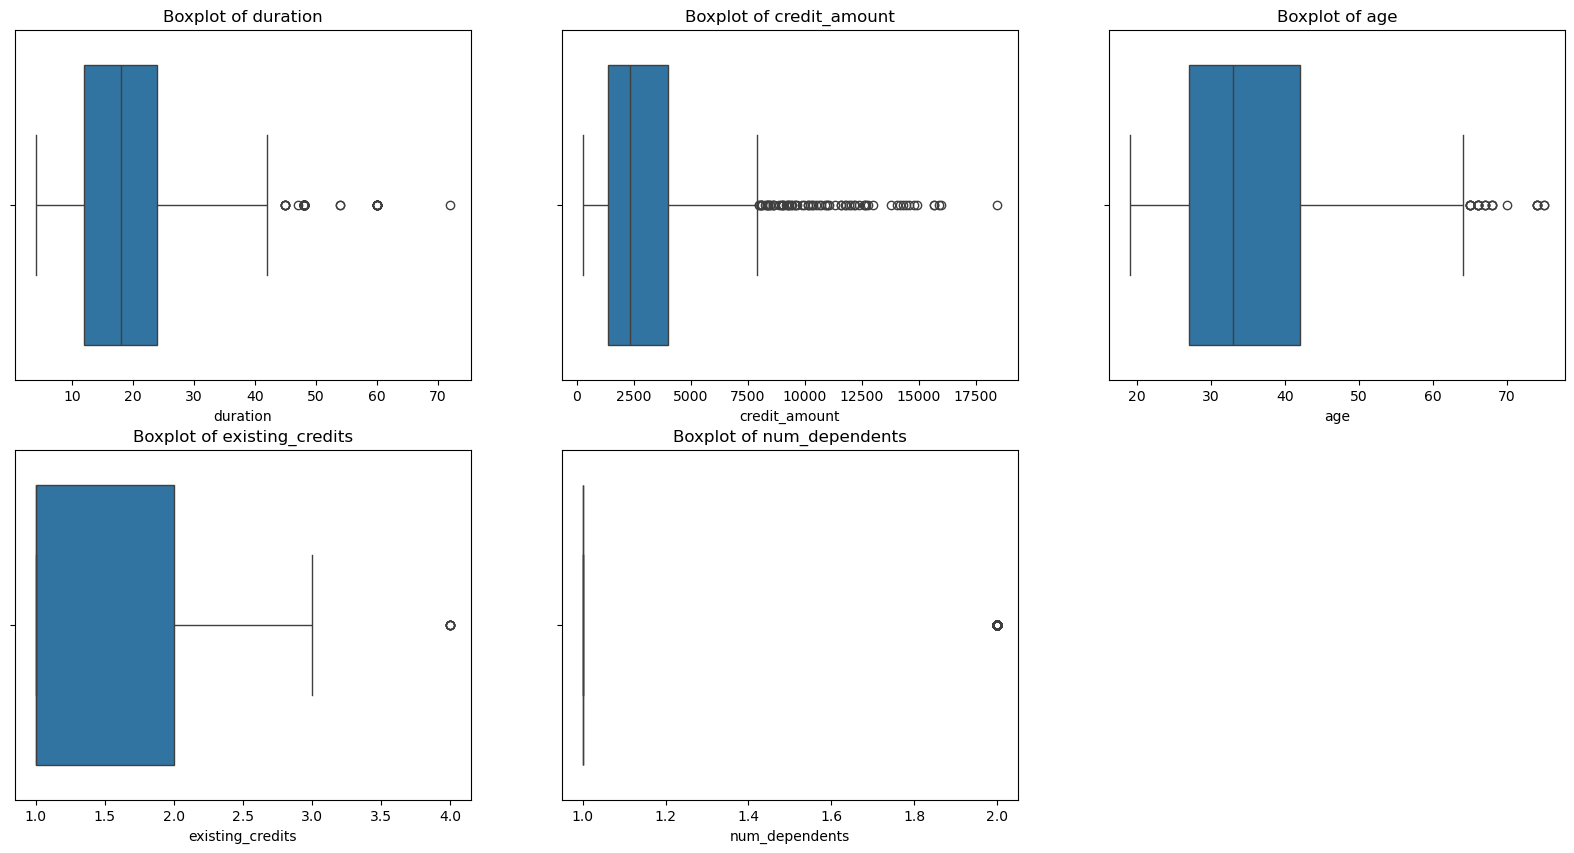

In [12]:
figure = plt.figure(figsize=(20, 10))

for i, col in enumerate(['duration', 'credit_amount', 'age', 'existing_credits', 'num_dependents']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')


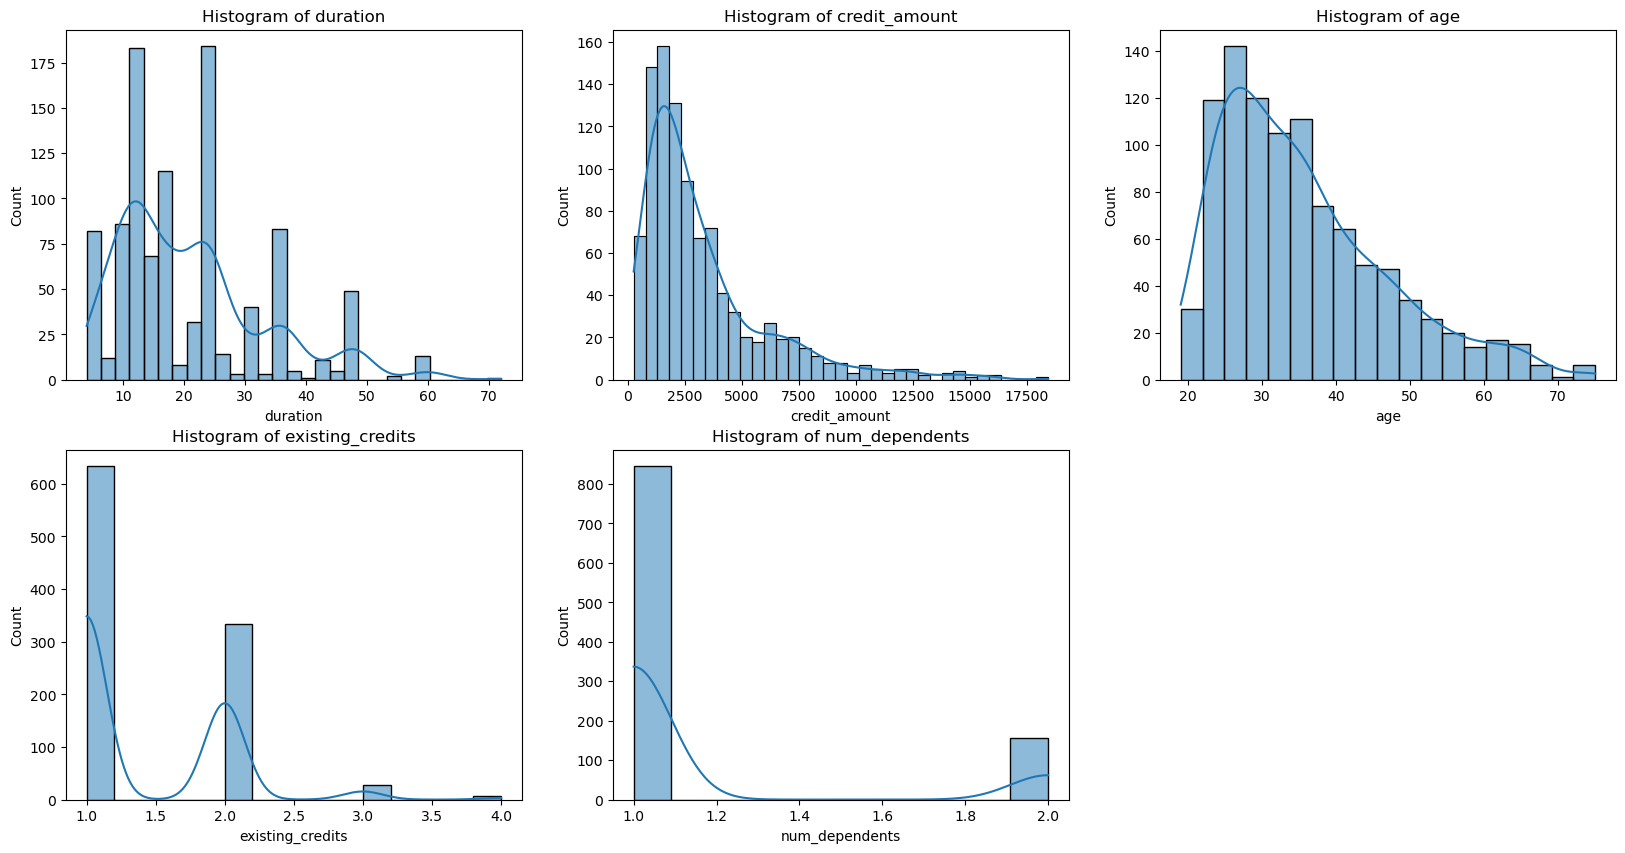

In [13]:
figure = plt.figure(figsize=(20, 10))

for i, col in enumerate(['duration', 'credit_amount', 'age', 'existing_credits', 'num_dependents']):
    plt.subplot(2, 3, i+1)
    sns.histplot(x=df[col], kde=True)
    plt.title(f'Histogram of {col}')

looking the graph we can see that the value are something that can real appen and represent unique value that can appen in real world, so I prefer to not remove them and neather cap. Move to look about the bivarate analisys with the target feature

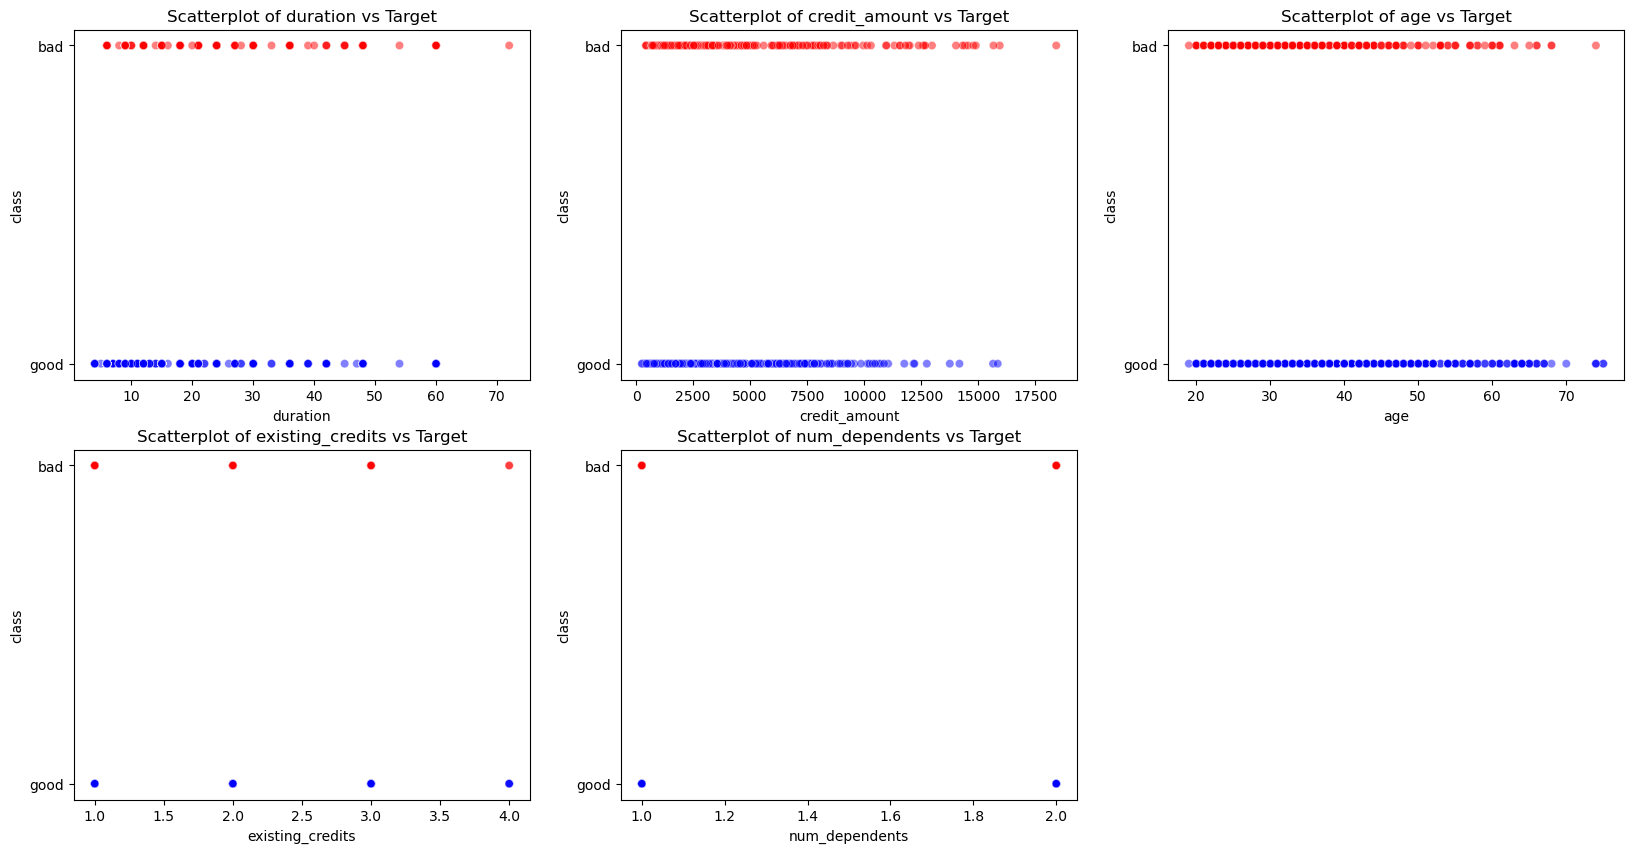

In [14]:
figure = plt.figure(figsize=(20, 10))
for i, col in enumerate(['duration', 'credit_amount', 'age', 'existing_credits', 'num_dependents']):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=df[col], y=df['class'], color=['blue' if c == 'good' else 'red' for c in df['class']], alpha=0.5)
    plt.title(f'Scatterplot of {col} vs Target')

the graphics don't help us to discover any patter so we will move to data processing due to they show that there aren't any inconsistent value

## Step 3 - Data processing

In this phase we convert the clean data in numerical and structured input

In [15]:
# first we separate numerical and categorical features
numerical_features = numerical_cols
categorical_features = df.select_dtypes(include=['category'])

print("Numerical features:")
print(numerical_features.columns)

categorical_features = df.select_dtypes(include=['category'])
print("Categorical features:")
print(categorical_features.columns)

Numerical features:
Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents'],
      dtype='object')
Categorical features:
Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')


In [16]:
# we need to convert categorical features into numerical using ordinal encoding to presever the natual order of the categories
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
categorical_features_encoded = pd.DataFrame(ordinal_encoder.fit_transform(categorical_features), columns=categorical_features.columns)

In [17]:
# display the first rows of the encoded categorical features to verify the conversion
categorical_features_encoded.head()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,class
0,1.0,1.0,6.0,4.0,3.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,3.0,6.0,2.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0
2,3.0,1.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0
3,1.0,3.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,1.0,2.0,4.0,2.0,0.0,3.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0


Now we can standardized the data to have better performance using neural network model

In [18]:
# standardization of numerical features using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_features_scaled = pd.DataFrame(scaler.fit_transform(numerical_features), columns=numerical_features.columns)

In [19]:
# combine numerical and encoded categorical features into a single dataframe
df_proc = pd.concat([numerical_features_scaled, categorical_features_encoded], axis=1)
df_proc.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status,credit_history,purpose,...,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,class
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1.0,1.0,6.0,...,3.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.0,3.0,6.0,...,0.0,0.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,3.0,1.0,2.0,...,1.0,3.0,2.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.0,3.0,3.0,...,1.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,1.0,2.0,4.0,...,0.0,3.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0


In [20]:
# now proceed to separate features and target
X = df_proc.drop(columns=['class'])
y = df_proc['class']

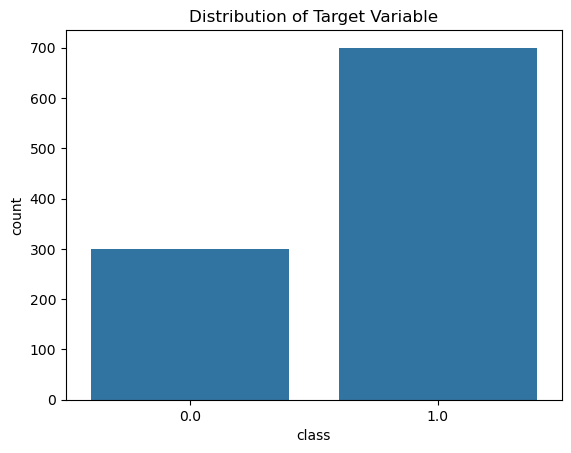

In [21]:
# now we can display the distribution of the target variable to check for class imbalance
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.show()

we can see that the class are imbalanced so we proceed to balacing them due to help the model to see a good number of example of each class to learn to predict correctly

In [22]:
# we use 3 techniques to balance the classes
ros = RandomOverSampler() # Random Over Sampling -- duplicate samples from the minority class
rus = RandomUnderSampler() # Random Under Sampling -- remove samples from the majority class
smote = SMOTE() # Synthetic Minority Over-sampling Technique -- create synthetic samples of the minority class

In [23]:
x1, y1 = ros.fit_resample(X, y) # first create duplicates of minority class
x2, y2 = smote.fit_resample(x1, y1) # then create synthetic samples of minority class
x3, y3 = rus.fit_resample(x2, y2) # last remove samples from majority class to have balanced classes

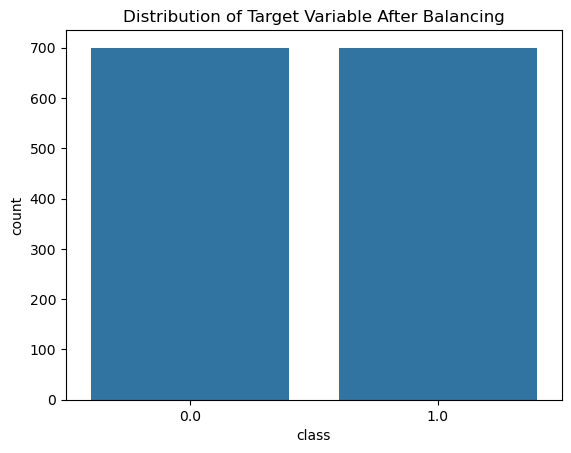

In [24]:
# display now the distribution of the target variable after balancing
sns.countplot(x=y3)
plt.title('Distribution of Target Variable After Balancing')
plt.show()

In [25]:
# now proceed to split the dataset into train test and validation sets
# we are using 70% of the data for training, 15% for validation and 15% for testing
# train data are used to fit the model, validation data to tune hyperparameters and test data to evaluate the final model performance
X_train, X_temp, y_train, y_temp = train_test_split(x3, y3, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Step 4 - Scelta e addestramento del modello
In this phase we are going to choose the prediction model which fit the best with the problem. In this case the problem to solve is classification. For this task the best model to use are Logistic Regression, Decision Tree, SVM, Random Forest, XGBoost and Neural Network

In [26]:
# We are going to choose only 3 models to compare: Random Forest, XGBoost and Neural Network
model_rf = RandomForestClassifier(n_estimators=2000, random_state=42, n_jobs=-1) # we set n_jobs=-1 to use all available cores and n_estimators=2000 indicates the number of trees in the forest and fixed random_state for reproducibility
model_xgb = XGBClassifier(n_estimators=2000, random_state=42, n_jobs=-1) # XGBoost model with 2000 trees
model_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000, random_state=42) # Neural Network with 100 hidden units

In [27]:
# now we train the models
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_nn.fit(X_train, y_train)

MLPClassifier(max_iter=2000, random_state=42)

In [28]:
# now we can get an initial evaluation of the models on the test set
y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_nn = model_nn.predict(X_test)

In [29]:
# show classification reports for each model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       111
         1.0       0.87      0.84      0.86        99

    accuracy                           0.87       210
   macro avg       0.87      0.87      0.87       210
weighted avg       0.87      0.87      0.87       210

Random Forest Confusion Matrix:
[[99 12]
 [16 83]]
XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       111
         1.0       0.86      0.86      0.86        99

    accuracy                           0.87       210
   macro avg       0.87      0.87      0.87       210
weighted avg       0.87      0.87      0.87       210

XGBoost Confusion Matrix:
[[97 14]
 [14 85]]
Neural Network Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85       111
         1.0       0.87      0.76  

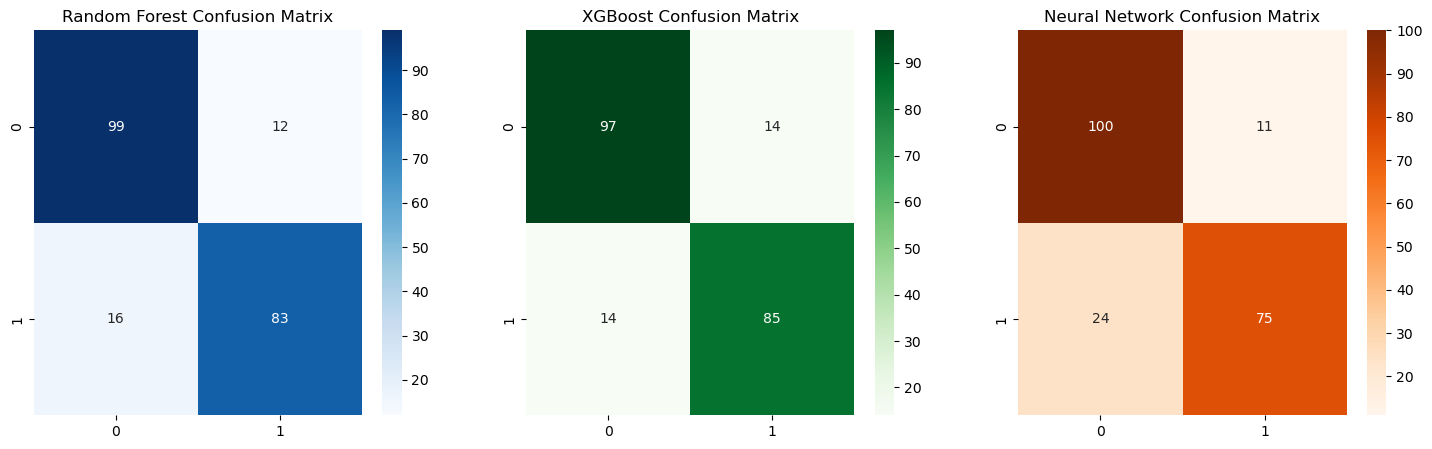

In [30]:
# display confusion matrices
figure = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost Confusion Matrix')
plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Oranges')
plt.title('Neural Network Confusion Matrix')
plt.show()

from this primary evaluation we can see that the best model is the Random forest algoritm whith little difference with XGBoost which has a either good performance. In last position we find the neural network with not a bad performance but it is the worst in this case

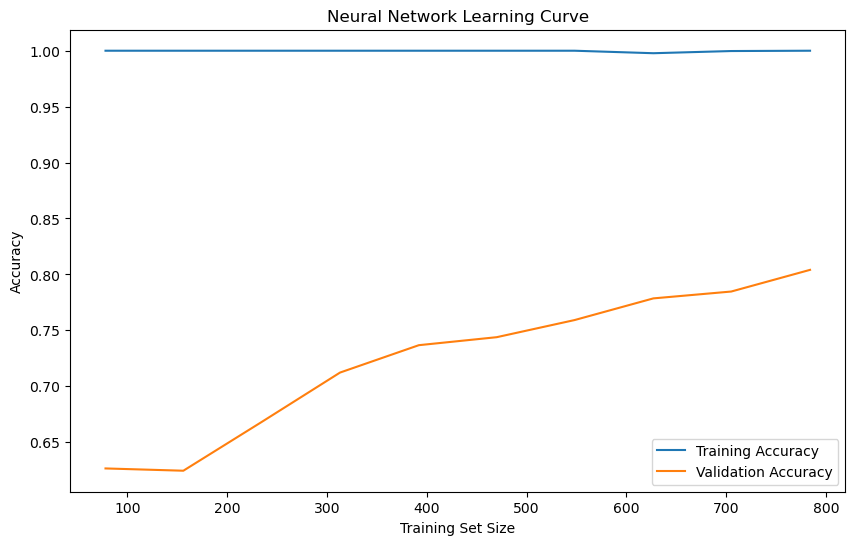

In [31]:
# analysis of neural network performance
# we are goind to display the learning curve to see if the model is underfitting or overfitting
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(model_nn, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Neural Network Learning Curve')
plt.legend()
plt.show()

from this graphic we can see that the model is affected by over-fitting problem, generaly because the model is too complex for the problem. We can try to resolve this problem by limiting some parameters

In [32]:
# now we can use a cross-validation technique to have a better evaluation of the models
from sklearn.model_selection import cross_val_score
cv_scores_rf = cross_val_score(model_rf, x3, y3, cv=5, scoring='f1', n_jobs=-1)
cv_scores_xgb = cross_val_score(model_xgb, x3, y3, cv=5, scoring='f1', n_jobs=-1)
cv_scores_nn = cross_val_score(model_nn, x3, y3, cv=5, scoring='f1', n_jobs=-1)

In [33]:
# process to display the cross-validation scores
print("Random Forest Cross-Validation F1 Scores:", cv_scores_rf)
print("Mean F1 Score:", np.mean(cv_scores_rf))
print("XGBoost Cross-Validation F1 Scores:", cv_scores_xgb)
print("Mean F1 Score:", np.mean(cv_scores_xgb))
print("Neural Network Cross-Validation F1 Scores:", cv_scores_nn)
print("Mean F1 Score:", np.mean(cv_scores_nn))

Random Forest Cross-Validation F1 Scores: [0.86131387 0.89679715 0.81451613 0.93536122 0.88      ]
Mean F1 Score: 0.8775976734800691
XGBoost Cross-Validation F1 Scores: [0.8164794  0.87857143 0.86046512 0.93129771 0.87096774]
Mean F1 Score: 0.871556279491742
Neural Network Cross-Validation F1 Scores: [0.78461538 0.82481752 0.79012346 0.90625    0.88      ]
Mean F1 Score: 0.8371612719307366


from this evaluation we can see that:
- Random Forest is continue performing the best; is stable and sturdy
- XGBoost is similar to Random Forest but with some fold who perform less well
- Neural Network continue to be the worst of the 3 model. This can be due to the limit number of data, NN need a great number of data to perform the best and hyperparameters are not perfectly optimized yet.

# step 5 - HyperParameters Tuning
In this phase we try different combination of hyperparameter to find the best who return the best score of the key metric

In [34]:
# for the step 5 we use a grid search approach to find the best hyperparameters for each model
from sklearn.model_selection import GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, scoring='f1', verbose=2)
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estim

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=2000, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1', verbose=2)

In [35]:
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Hyperparameters:", grid_search_rf.best_params_)

Best Random Forest Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [36]:
# now we tune hyperparameters for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_lambda': [1, 5, 10]
}
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, scoring='f1', verbose=2)
grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda=1, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_lambda

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=2000,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500],
                         'reg_lambda': [1, 5, 10],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='f1', verbose=2)

In [37]:
best_xgb = grid_search_xgb.best_estimator_
print("Best XGBoost Hyperparameters:", grid_search_xgb.best_params_)

Best XGBoost Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 1, 'subsample': 0.7}


In [38]:
# last we tune hyperparameters for Neural Network
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64), (64, 32, 16)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2],     # regolarizzazione L2
    'learning_rate_init': [0.0005, 0.001, 0.005],
    'solver': ['adam'],
    'early_stopping': [True]
}
grid_search_mlp = GridSearchCV(estimator=model_nn, param_grid=param_grid_mlp, cv=3, n_jobs=-1, scoring='f1', verbose=2)
grid_search_mlp.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END activation=relu, alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50,), learning_rate_init=0.0005, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50,), learning_rate_init=0.0005, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50,), learning_rate_init=0.0005, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50,), learning_rate_init=0.005, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50,), learning_rate_init=0.005, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, early_stopping=True, hidden_lay

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [1e-05, 0.0001, 0.001, 0.01],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(50,), (100,), (100, 50),
                                                (128, 64), (64, 32, 16)],
                         'learning_rate_init': [0.0005, 0.001, 0.005],
                         'solver': ['adam']},
             scoring='f1', verbose=2)

In [39]:
best_nn = grid_search_mlp.best_estimator_
print("Best Neural Network Hyperparameters:", grid_search_mlp.best_params_)

Best Neural Network Hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.005, 'solver': 'adam'}


## step 5 validation best model

In [40]:
# now we see if the best models found with hyperparameter tuning perform better on test set
y_pred_best_rf = best_rf.predict(X_test)
y_pred_best_xgb = best_xgb.predict(X_test)
y_pred_best_nn = best_nn.predict(X_test)

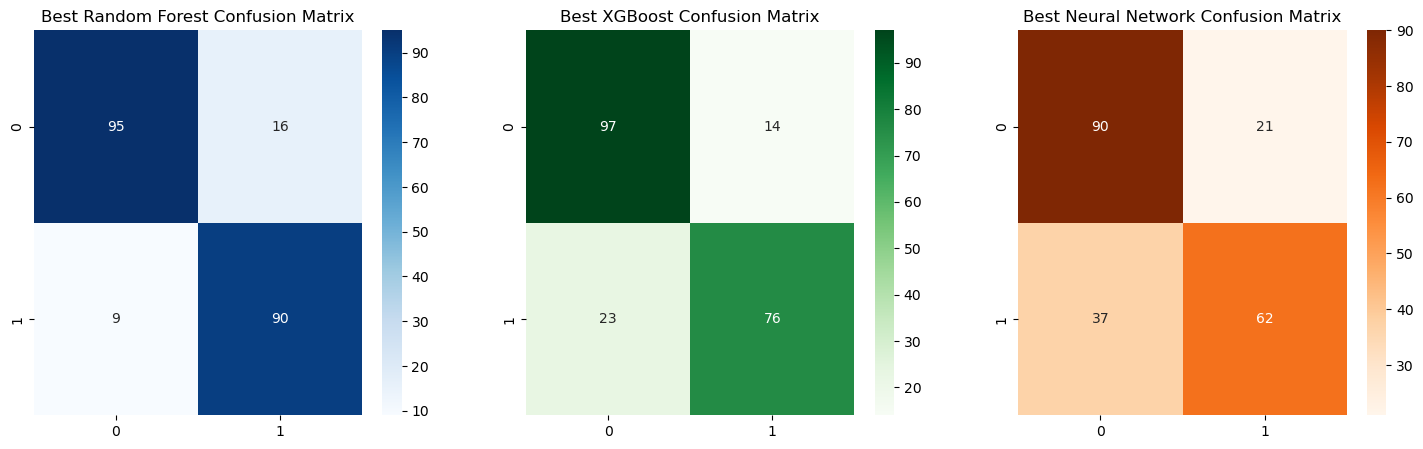

In [41]:
# display the confusion matrices graphically
figure = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_best_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Best Random Forest Confusion Matrix')
plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_best_xgb), annot=True, fmt='d', cmap='Greens')
plt.title('Best XGBoost Confusion Matrix')
plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_best_nn), annot=True, fmt='d', cmap='Oranges')
plt.title('Best Neural Network Confusion Matrix')
plt.show()

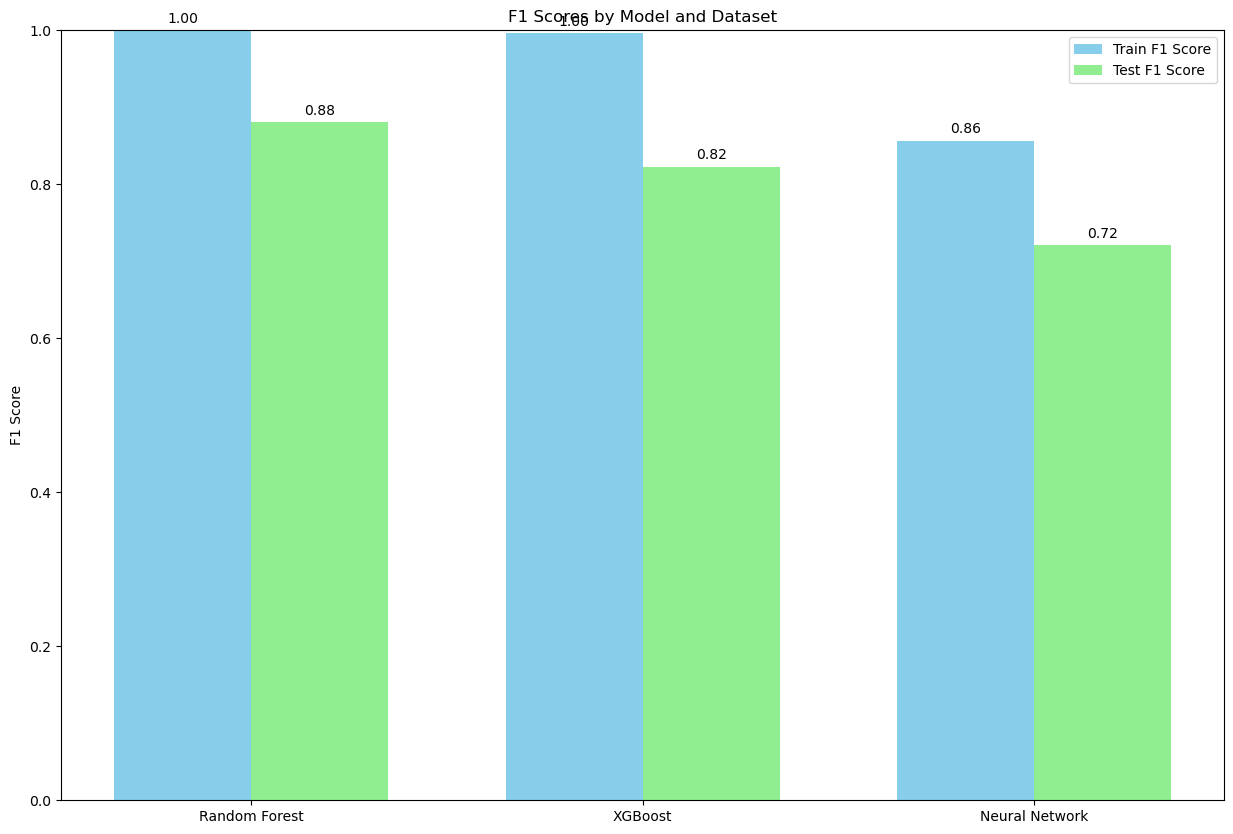

In [42]:
# now i confront the performance of the best models after hyperparameter tuning on train set and test set using graphical representation
models = ['Random Forest', 'XGBoost', 'Neural Network']
train_f1_scores = [
    classification_report(y_train, best_rf.predict(X_train), output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_train, best_xgb.predict(X_train), output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_train, best_nn.predict(X_train), output_dict=True)['weighted avg']['f1-score']
]
test_f1_scores = [
    classification_report(y_test, y_pred_best_rf, output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, y_pred_best_xgb, output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, y_pred_best_nn, output_dict=True)['weighted avg']['f1-score']
]
x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(15, 10))
bars1 = ax.bar(x - width/2, train_f1_scores, width, label='Train F1 Score', color='skyblue')
bars2 = ax.bar(x + width/2, test_f1_scores, width, label='Test F1 Score', color='lightgreen')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Model and Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bars1)
autolabel(bars2)
plt.ylim(0, 1)
plt.show()

In [43]:
# now the last thing is to analyze how the best models perform on validation set, testing the generalization capability
y_val_best_rf = best_rf.predict(X_val)
y_val_best_xgb = best_xgb.predict(X_val)
y_val_best_nn = best_nn.predict(X_val)

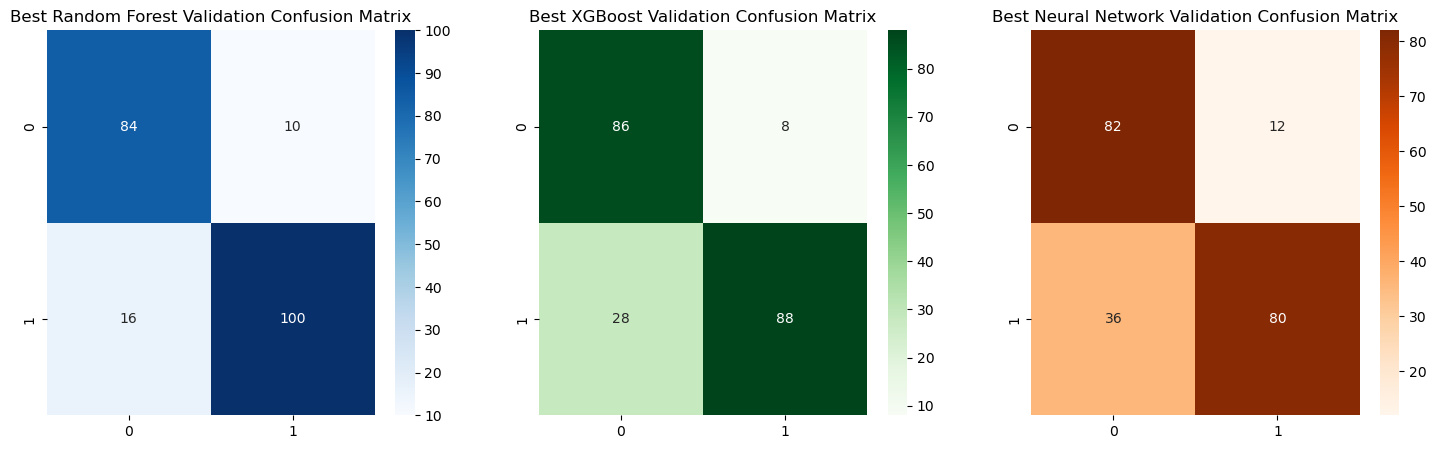

In [44]:
# display the confusion matrices for validation set
figure = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_val, y_val_best_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Best Random Forest Validation Confusion Matrix')
plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_val, y_val_best_xgb), annot=True, fmt='d', cmap='Greens')
plt.title('Best XGBoost Validation Confusion Matrix')
plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_val, y_val_best_nn), annot=True, fmt='d', cmap='Oranges')
plt.title('Best Neural Network Validation Confusion Matrix')
plt.show()

from this confusion matrix we can see that the best model continue to be the Random Forest, just followed by XGBoost. So I decide to chosse RFC as model to produce and terminate the study

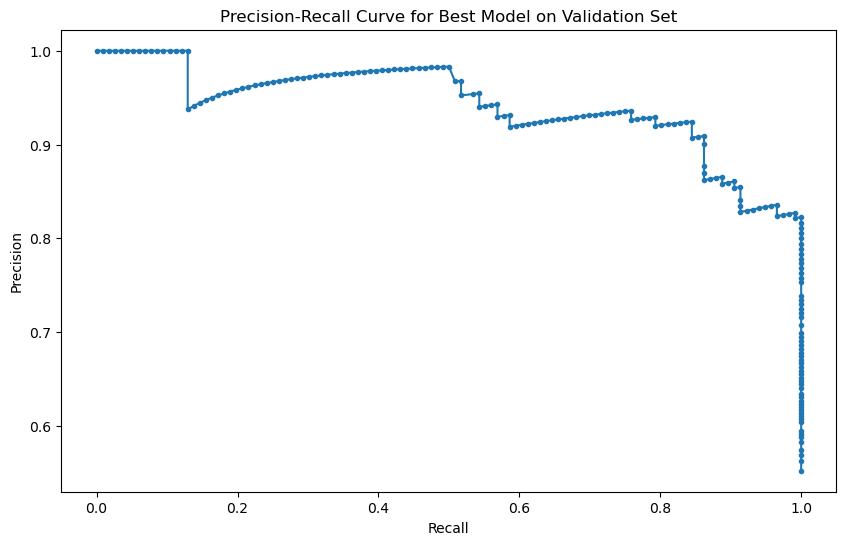

In [45]:
from sklearn.metrics import precision_recall_curve

best_model = best_rf  # assuming Random Forest is the best model

y_scores = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Best Model on Validation Set')
plt.show()

### Precision–Recall Curve Analysis (Random Forest on Validation Set)

The Precision–Recall (PR) curve illustrates the trade-off between **precision** (the proportion of correctly identified defaulters among all predicted defaulters) and **recall** (the proportion of actual defaulters correctly identified by the model).

In the graph above, we observe:

- **Precision remains very high (> 0.9)** over a large range of recall values (up to around 0.8).
- As recall increases toward 1.0, **precision gradually decreases**, indicating that the model starts classifying more borderline cases as defaulters, increasing the number of false positives.
- The model shows an **excellent balance** between detecting bad credit cases (high recall) and avoiding false alarms (high precision).

#### Interpretation in the Credit-Default Context
In credit scoring, the cost of a **false negative** (granting a loan to a risky customer) is typically much higher than a **false positive** (rejecting a good customer).  
This PR curve indicates that the Random Forest model can achieve **recall around 0.8** while maintaining **precision above 0.9**, which represents an optimal trade-off between business risk and customer acceptance.

#### Practical Use
Rather than keeping the default probability threshold at 0.5, we can choose a **custom decision threshold** that maximizes the F1-score or ensures a desired recall level.  
This allows us to fine-tune the model according to the organization’s risk appetite:


In [46]:
from sklearn.metrics import precision_recall_curve, f1_score

y_scores = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Calcola F1 per ogni soglia
f1 = 2 * (precision * recall) / (precision + recall)

# Soglia ottimale
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

print(f"Miglior soglia: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1[best_idx]:.3f}")

Miglior soglia: 0.207
Precision: 0.823, Recall: 1.000, F1: 0.903


## Model Interpretability — Random Forest Classifier (Credit Default Prediction)

To understand how the Random Forest model makes predictions about credit risk, several interpretability techniques were applied at both **global** (model-level) and **local** (individual prediction) scales.

---



---


---


---

### Summary

| Interpretation Level | Technique | Purpose | Key Takeaway |
|-----------------------|------------|-----------|---------------|
| **Global** | Permutation Importance | Identifies key drivers of model accuracy | Checking account status and loan duration dominate model influence |
| **Global** | Partial Dependence | Shows average direction of effect | Longer durations and older age reduce default risk |
| **Individual** | ICE Plot | Reveals customer-level variability | Effect of credit amount differs across applicants |
| **Local** | LIME | Explains one decision transparently | Model attributes decision to financial stability indicators |

Overall, the Random Forest model captures realistic relationships between credit features and default risk, maintaining both **predictive strength** and **interpretability**.


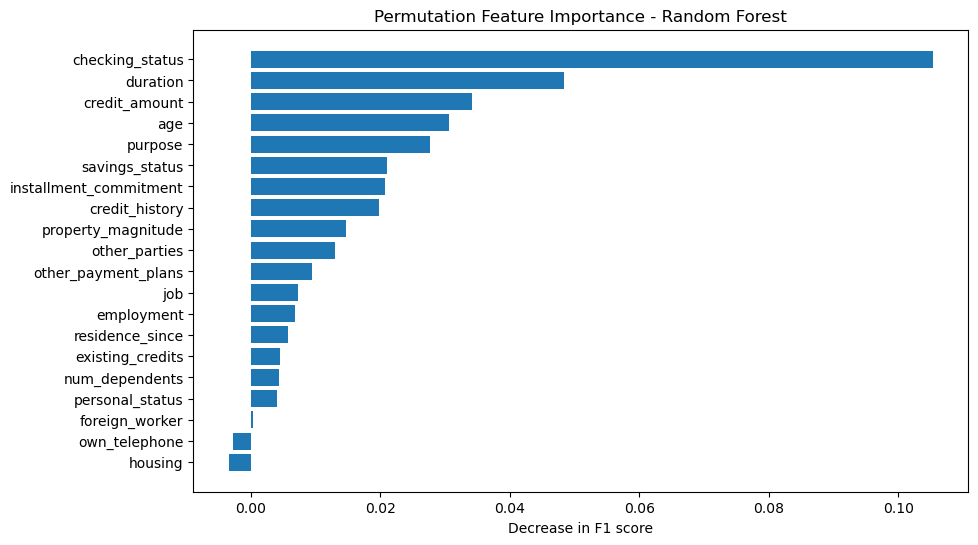

In [77]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_model, X_val, y_val, scoring='f1', n_repeats=10, random_state=42)

perm_df = pd.DataFrame({'Feature': X_val.columns, 'Importance': r.importances_mean})
perm_df = perm_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(perm_df['Feature'], perm_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance - Random Forest")
plt.xlabel("Decrease in F1 score")
plt.show()


### Permutation Feature Importance

**Description:**  
This chart shows the decrease in model performance (F1 score) when each feature is randomly permuted.  
A larger drop means the feature is more important for accurate predictions.

**Insights:**
- `checking_status` is by far the most influential feature, followed by `duration` and `credit_amount`.
- These variables dominate the model’s ability to separate good and bad credit applicants.
- Features such as `housing`, `own_telephone`, and `foreign_worker` have minimal influence.


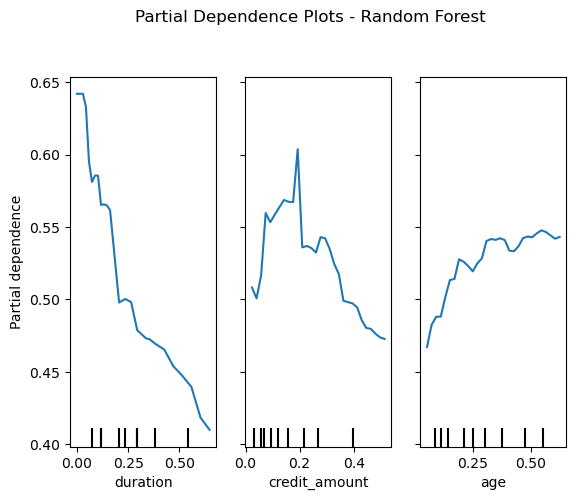

In [78]:
from sklearn.inspection import PartialDependenceDisplay

# Scegli alcune feature chiave da visualizzare
features_to_plot = ['duration', 'credit_amount', 'age']

PartialDependenceDisplay.from_estimator(
    best_model, X_val, features_to_plot, kind="average", grid_resolution=30
)
plt.suptitle("Partial Dependence Plots - Random Forest", y=1.02)
plt.show()


### Partial Dependence Plots (PDP)

**Description:**  
PDPs illustrate the **average effect** of a single feature on the predicted probability of default, keeping all other features constant.

**Observations:**
- **Duration:** As the loan duration increases, the probability of default decreases steadily.  
- **Credit Amount:** Higher credit amounts slightly increase default risk, though the relationship is non-linear.  
- **Age:** Older clients tend to have a lower probability of default.

These patterns help interpret how the model internally evaluates risk factors.

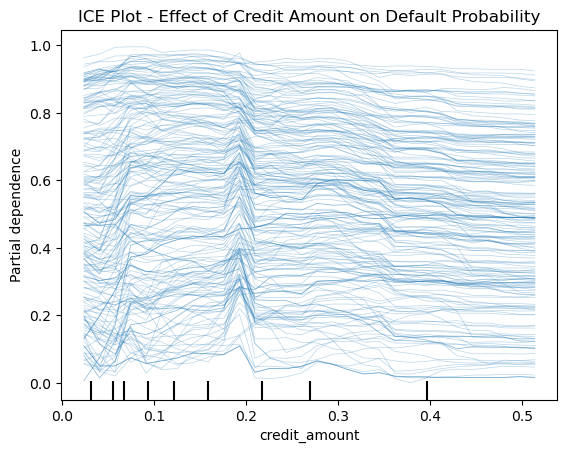

In [79]:
PartialDependenceDisplay.from_estimator(
    best_model, X_val, ['credit_amount'], kind="individual", grid_resolution=30
)
plt.title("ICE Plot - Effect of Credit Amount on Default Probability")
plt.show()


### Individual Conditional Expectation (ICE)


**Description:**  
ICE plots extend PDPs by showing **individual-level effects** instead of the average. Each line represents one applicant.

**Observations:**
- For most customers, an increase in `credit_amount` raises the predicted risk, but the magnitude varies widely.
- This variability highlights **heterogeneous effects** — the model reacts differently to the same feature depending on other attributes (e.g., income or savings).

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Good Credit', 'Bad Credit'],
    mode='classification'
)

# Spiegazione per un singolo cliente
i = 0
exp = explainer.explain_instance(
    data_row=X_val.iloc[i],
    predict_fn=best_model.predict_proba
)
exp.show_in_notebook(show_table=True)

/opt/anaconda3/envs/SN25/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/envs/SN25/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/opt/anaconda3/envs/SN25/lib/python3.13/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

### Local Explanation — LIME Visualization

**Description:**  
This visualization explains the model’s decision for a single customer using **LIME** (Local Interpretable Model-agnostic Explanations).

**Interpretation:**
- The model predicted **“Bad Credit”** with a probability of **0.71**.
- The strongest contributing factors were:
  - `checking_status = 3` (+0.18 toward “Bad Credit”)
  - `duration = 0.56` (+0.10)
  - `credit_amount = 0.38` (+0.08)
- Features like `savings_status` and `installment_commitment` also increased risk, while others (e.g., `personal_status`, `existing_credits`) slightly reduced it.

This local interpretability helps **justify individual credit decisions**, a key requirement in regulated financial contexts.
